In [1]:
# Core
import re, os, glob
import pandas as pd
from scipy import stats
import numpy as np
import csv
# Plotting
%matplotlib inline
%config InlineBackend.figure_format ='retina'
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
rcParams['font.sans-serif'] = "Arial"
rcParams['font.family'] = "sans-serif"
import matplotlib.patches as mpatches
from matplotlib.dates import DateFormatter
from datetime import datetime, timedelta
import matplotlib.dates as mdates
# Custom defs
from helpers import get_plot_height, Vividict

## Test Titrations
These are indicator samples that we used to determine when each species and genotype switched to CAM.

In [2]:
test_titrations = pd.read_csv("../Data/Test_titrations.csv")
test_titrations.dropna(inplace=True)
test_titrations["datetime"] = [" ".join([row["Date"], row["Time"]]) for i, row in test_titrations.iterrows()]
test_titrations["datetime"] = [datetime.strptime(dt, "%d %B %Y %H:%M") for dt in test_titrations["datetime"]]
test_titrations.head()

,Date,Time,Sample,Mass_g,pHi,uL_NaOH,pHf,ueq_H,datetime
0,12 February 2019,16:00,AM,0.22245,5.64,831.0,7.03,7.47,2019-02-12 16:00:00
1,12 February 2019,16:00,OR,0.21921,5.97,440.0,7.00,4.01,2019-02-12 16:00:00
2,12 February 2019,16:00,OF,0.23501,5.61,940.0,7.03,8.00,2019-02-12 16:00:00
3,13 February 2019,4:00,OF,0.15241,6.03,523.0,7.03,6.86,2019-02-13 04:00:00
4,13 February 2019,4:00,AM,0.17704,5.28,1246.0,7.01,14.08,2019-02-13 04:00:00


/Users/iangilman/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


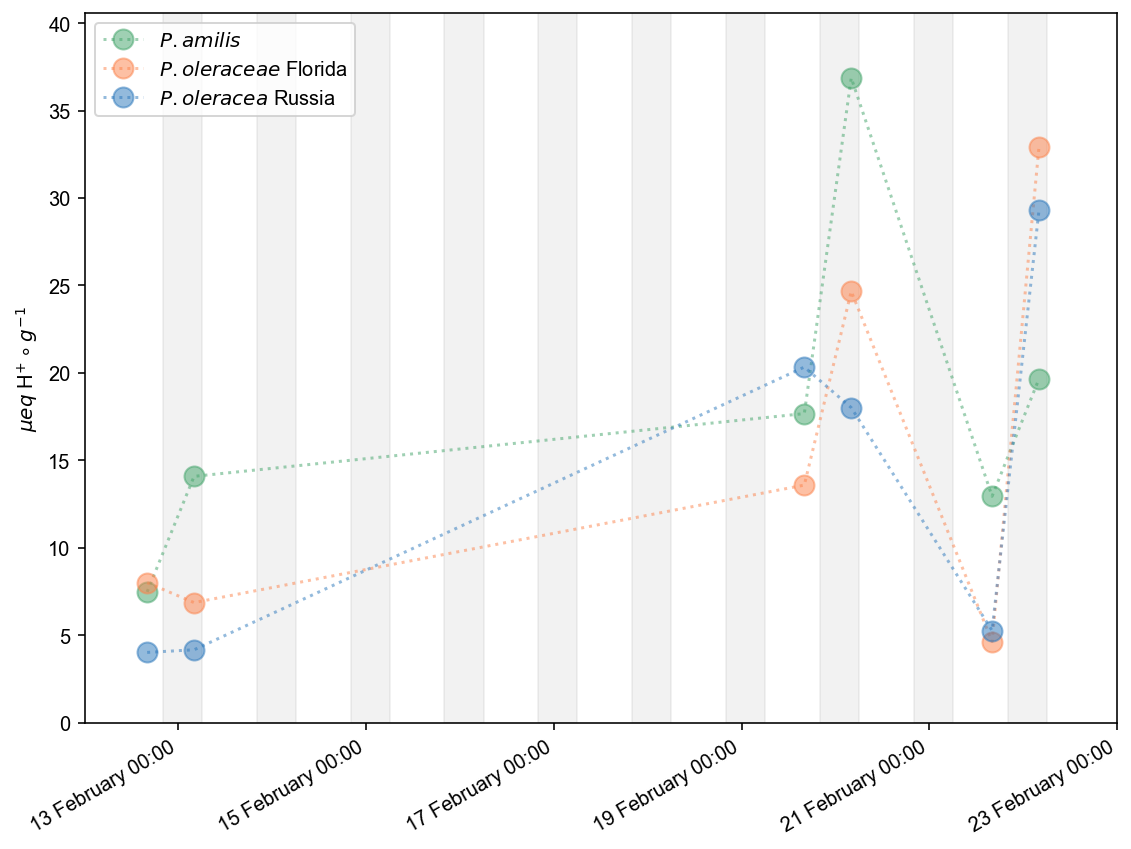

In [3]:
fig, ax = plt.subplots(figsize = (8,6))

for i in range(12, 22, 1):
    rect = mpatches.Rectangle((datetime(2019, 2, i, 20), 0), timedelta(hours = 10), 
                              1000, color='grey', alpha=0.10)
    ax.add_patch(rect) 
    
ax.plot_date(x = test_titrations.loc[test_titrations["Sample"]=="AM"]["datetime"], 
           y = test_titrations.loc[test_titrations["Sample"]=="AM"]["ueq_H"], linestyle=":",
           color = "xkcd:greenish", marker = "o", label = "$P. amilis$", alpha = 0.5, markersize=10)
ax.plot_date(x = test_titrations.loc[test_titrations["Sample"]=="OF"]["datetime"], 
           y = test_titrations.loc[test_titrations["Sample"]=="OF"]["ueq_H"], linestyle=":", 
           color = "xkcd:orangish", marker = "o", label = "$P. oleraceae$ Florida", alpha = 0.5, markersize=10)
ax.plot_date(x = test_titrations.loc[test_titrations["Sample"]=="OR"]["datetime"], 
           y = test_titrations.loc[test_titrations["Sample"]=="OR"]["ueq_H"], linestyle=":", 
           color = "xkcd:bluish", marker = "o", label = "$P. oleracea$ Russia", alpha = 0.5, markersize=10)
plt.legend(loc = "upper left")

ax.set_xlim([datetime(2019, 2, 12, 0), datetime(2019, 2, 23, 0)])
ax.set_ylim([0, test_titrations["ueq_H"].max()*1.1])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %B %H:%M'))
ax.set_ylabel("$\mu eq$ H$^{+}\circ g^{-1}$")
fig.autofmt_xdate()
plt.tight_layout()

# Experimental titrations
Since we confirmed CAM in the indicator specimens, we continued with sampling and titrations for the experimental plants. The results are below.

In [4]:
titrations = pd.read_csv("../Data/Titration_measurements.csv")
titrations["datetime"] = [datetime.strptime(dt, "%d %B %Y %H:%M") for dt in titrations["Collection time"]]
titrations["Genotype"] = [acc[:2] for acc in titrations["Acc_No"]]
titrations.head()

,Index,Collection time,Acc_No,Mass_g,pHi,uL_NaOH,pHf,ueq_H,Notes,datetime,Genotype
0,T_001,12 February 2019 16:00,AM02,0.44058,5.39,1975,7.03,8.965,NaN,2019-02-12 16:00:00,AM
1,T_002,12 February 2019 16:00,AM01,0.39618,5.78,1565,7.01,7.900,NaN,2019-02-12 16:00:00,AM
2,T_003,12 February 2019 16:00,OR01,0.20850,5.70,1478,7.05,14.177,NaN,2019-02-12 16:00:00,OR
3,T_004,12 February 2019 16:00,OR03,0.17567,5.43,1336,7.03,15.210,NaN,2019-02-12 16:00:00,OR
4,T_005,12 February 2019 16:00,AM03,0.28373,5.52,1024,7.02,7.218,NaN,2019-02-12 16:00:00,AM


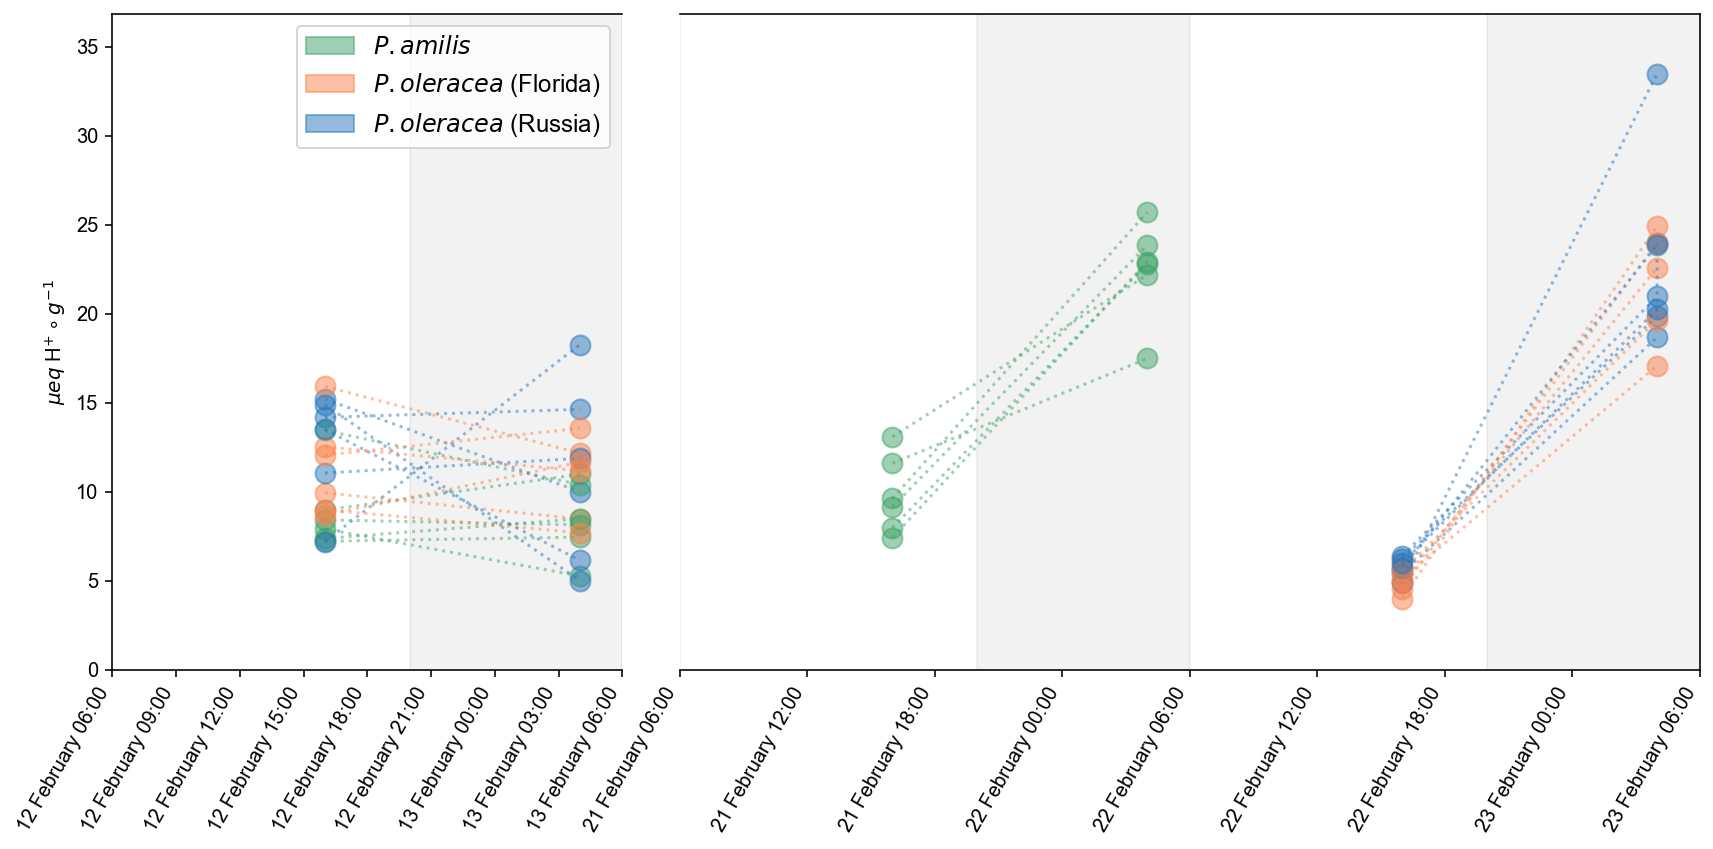

In [5]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize = (12,6), sharey=True, gridspec_kw = {'width_ratios':[1, 2]})

for ax in [ax0, ax1]:
    for i in range(11, 24, 1):
        rect = mpatches.Rectangle((datetime(2019, 2, i, 20), 0), timedelta(hours = 10), 
                                  1000, color='grey', alpha=0.10)
        ax.add_patch(rect) 
    
for acc in titrations["Acc_No"].unique():
    if acc.startswith("AM"):
        color = "xkcd:greenish"
        label = "$P. amilis$"
    if acc.startswith("OF"):
        color = "xkcd:orangish"
        label = "$P. oleraceae$ Florida"
    if acc.startswith("OR"):
        color = "xkcd:bluish"
        label = "$P. oleraceae$ Russia"

    ax0.plot_date(
        x = titrations.loc[(titrations["Acc_No"]==acc) & (titrations["datetime"]<datetime(2019,2,16))]["datetime"], 
        y = titrations.loc[(titrations["Acc_No"]==acc) & (titrations["datetime"]<datetime(2019,2,16))]["ueq_H"], 
        color = color, linestyle= ":", marker = "o", label = label, alpha = 0.5, markersize=10)
    ax1.plot_date(
        x = titrations.loc[(titrations["Acc_No"]==acc) & (titrations["datetime"]>datetime(2019,2,16))]["datetime"], 
        y = titrations.loc[(titrations["Acc_No"]==acc) & (titrations["datetime"]>datetime(2019,2,16))]["ueq_H"], 
        color = color, linestyle= ":", marker = "o", label = label, alpha = 0.5, markersize=10)

# Legend
green_patch = mpatches.Patch(color='xkcd:greenish', alpha=0.5, label='$P. amilis$')
orange_patch = mpatches.Patch(color='xkcd:orangish', alpha=0.5, label='$P. oleracea$ (Florida)')
blue_patch = mpatches.Patch(color='xkcd:bluish', alpha=0.5, label='$P. oleracea$ (Russia)')
ax0.legend(handles=[green_patch, orange_patch, blue_patch], fontsize=12, frameon=True)
# Partially remove frame
ax0.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.yaxis.set_ticks_position('none')
# Set plot limits
ax0.set_xlim([datetime(2019, 2, 12, 6), datetime(2019, 2, 13, 6)])
ax0.set_ylim([0, get_plot_height(ax=ax0, expansion=1.1)])
ax0.xaxis.set_major_formatter(mdates.DateFormatter('%d %B %H:%M'))
ax1.set_xlim([datetime(2019, 2, 21, 6), datetime(2019, 2, 23, 6)])
ax1.set_ylim([0, titrations["ueq_H"].max()*1.1])
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d %B %H:%M'))
# Format axes labels and adjust plot gaps
ax0.set_ylabel("$\mu eq$ H$^{+}\circ g^{-1}$")
fig.autofmt_xdate(rotation=60)
plt.tight_layout(w_pad=-2)

It looks like we see little or no change in titratable acidity for the control (well watered) plants and large jumps in acidity in our experimental (droughted) plants. We can look at the distribution of titratable acidity for each genotype using a box plot.

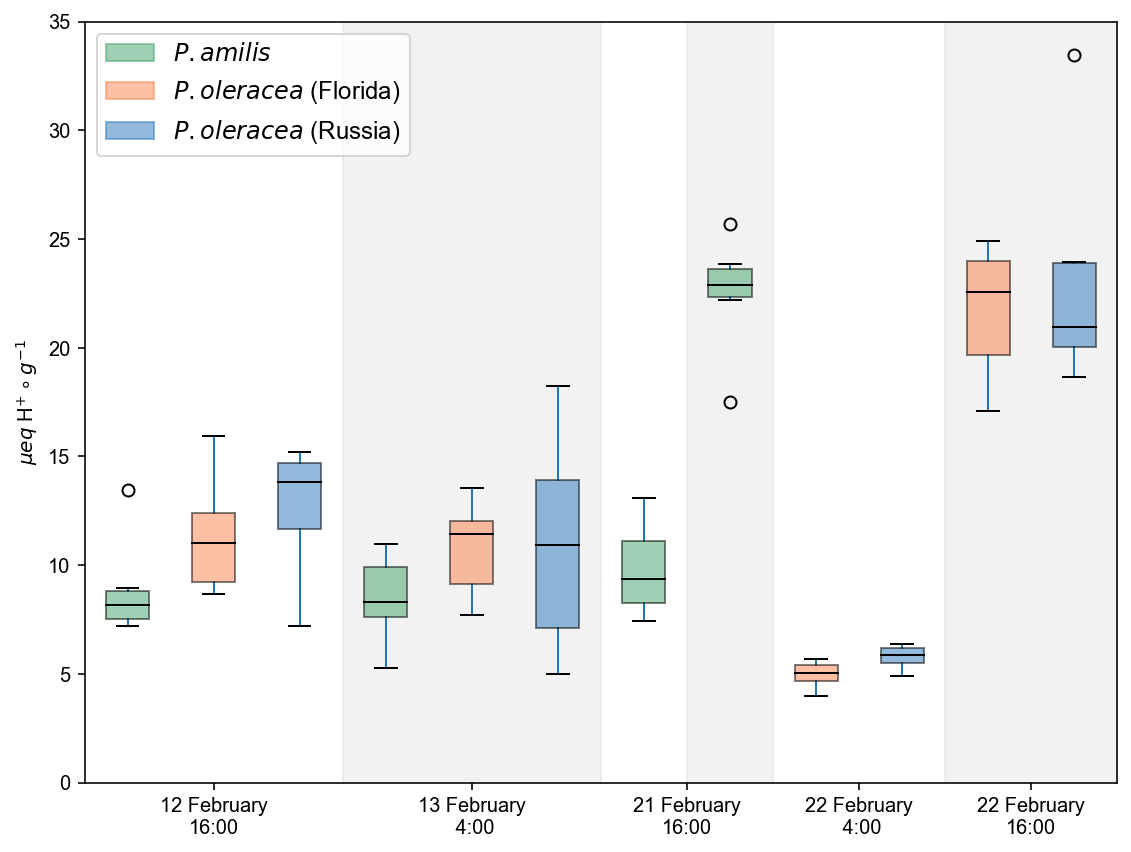

In [6]:
fig, ax = plt.subplots(figsize = (8,6))

nights = [[3.5, 6.5], [7.5, 8.5], [10.5, 12.5]]
for night in nights:
    rect = mpatches.Rectangle(xy=[night[0],0], width = night[1]-night[0], height= 40, color='grey', alpha=0.10)
    ax.add_patch(rect) 

boxplot_dict = titrations.boxplot(column=["ueq_H"], by=['datetime', 'Genotype'], ax=ax, 
                                  grid=False, return_type='both', patch_artist = True)

colors = ["xkcd:greenish", "xkcd:orangish", "xkcd:bluish",
          "xkcd:greenish", "xkcd:orangish", "xkcd:bluish",
          "xkcd:greenish", "xkcd:greenish", 
          "xkcd:orangish", "xkcd:bluish",
          "xkcd:orangish", "xkcd:bluish",]

for row_key, (ax,row) in boxplot_dict.iteritems():
    ax.set_xlabel('')
    for i,box in enumerate(row['boxes']):
        box.set_facecolor(colors[i])
        box.set_edgecolor("black")
        box.set_alpha(0.5)
    for i,median in enumerate(row['medians']):
        median.set_color("black")

green_patch = mpatches.Patch(color='xkcd:greenish', alpha=0.5, label='$P. amilis$')
orange_patch = mpatches.Patch(color='xkcd:orangish', alpha=0.5, label='$P. oleracea$ (Florida)')
blue_patch = mpatches.Patch(color='xkcd:bluish', alpha=0.5, label='$P. oleracea$ (Russia)')
ax.legend(handles=[green_patch, orange_patch, blue_patch], fontsize=12, frameon=True)

ax.set_xlim(0.5,12.5)
ax.set_ylim([0, 35])

ax.set_ylabel("$\mu eq$ H$^{+}\circ g^{-1}$")
ax.set_xlabel("")
ax.set_title("")
ax.set_xticks([2, 5, 7.5, 9.5, 11.5])
ax.set_xticklabels(["12 February\n16:00", "13 February\n 4:00", 
                    "21 February\n16:00", "22 February\n 4:00", 
                    "22 February\n16:00", "23 February\n 4:00",])
plt.suptitle("")
plt.tight_layout()

But this way of parsing the data may mask the _change_ in titratable acidity, $\Delta$H$^{+}$ on a _specimen-by-specimen_ basis, which is what we're really interested in. Now we'll aggregate individual $\Delta$H$^{+}$ by genotype and use a t-test to test deviation from a population mean of 0 (i.e. no change in titratable acidity).

In [7]:
dH_dict = Vividict()
for acc, group in titrations.groupby("Acc_No"):
    try:
        dH_dict[acc]["Genotype"] = acc[:2]
        dH_dict[acc]["water"] = group.iloc[1]["ueq_H"]-group.iloc[0]["ueq_H"]
        dH_dict[acc]["drought"] = group.iloc[3]["ueq_H"]-group.iloc[2]["ueq_H"]
    except IndexError:
        next
        
dH = pd.DataFrame(dH_dict).T.reset_index()
dH.columns = ["Acc_No", "Genotype", "water", "drought"]
dH.head()

,Acc_No,Genotype,water,drought
0,AM01,AM,-2.631,15.509
1,AM02,AM,2.013,5.888
2,AM03,AM,0.232,14.71
3,AM04,AM,1.113,16.083
4,AM05,AM,-0.275,9.097


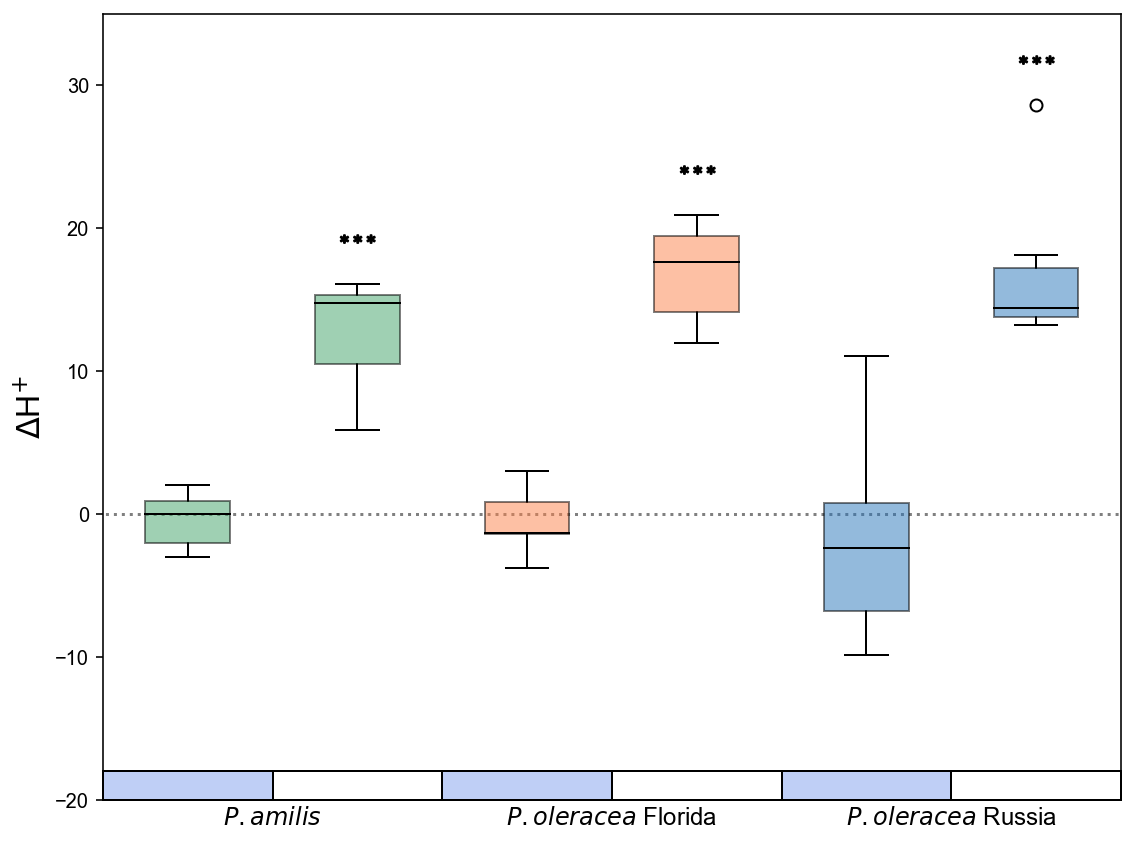

In [8]:
fig, ax = plt.subplots(figsize = (8,6))

for i in [0.5, 2.5, 4.5]:
    ax.add_patch(plt.Rectangle(xy = (i,-20), width = 1 , height = 2,
                               facecolor='xkcd:blue', alpha=0.25, clip_on=False, linewidth = 1))
    ax.add_patch(plt.Rectangle(xy = (i,-20), width = 1 , height = 2, 
                               facecolor="none", clip_on=False, edgecolor ="black", linewidth = 1))
ax.add_patch(plt.Rectangle(xy = (0.5,-20), width = 6 , height = 2, 
                           facecolor="none", clip_on=False, edgecolor ="black", linewidth = 1))
ax.hlines(y=0, xmin=0, xmax=6.5, colors="grey", linestyles=":")

AM_w = dH.loc[dH["Genotype"]=="AM"]["water"]
AM_d = dH.loc[dH["Genotype"]=="AM"]["drought"]
OF_w = dH.loc[dH["Genotype"]=="OF"]["water"].dropna()
OF_d = dH.loc[dH["Genotype"]=="OF"]["drought"].dropna()
OR_w = dH.loc[dH["Genotype"]=="OR"]["water"]
OR_d = dH.loc[dH["Genotype"]=="OR"]["drought"]

boxplot = ax.boxplot(patch_artist=True, x = [AM_w, AM_d, OF_w, OF_d, OR_w, OR_d])

for i, dist in enumerate([AM_w, AM_d, OF_w, OF_d, OR_w, OR_d]):
    result = stats.ttest_1samp(a=dist, popmean=0)
    if result.pvalue < 0.001: 
        marker = "$*$ $*$ $*$"
        size = 300
    elif result.pvalue < 0.01: 
        marker = "$*$ $*$"
        size = 300
    elif result.pvalue < 0.05: 
        marker = "$*$"
        size = 50
    else: 
        marker = ""
        size = 50
    ax.scatter(x = i+1, y = max(dist)+3, marker=marker, c="black", s=size)

colors = ["xkcd:greenish", "xkcd:greenish", "xkcd:orangish", "xkcd:orangish", "xkcd:bluish", "xkcd:bluish"]
for color, box in zip(colors, boxplot["boxes"]):
    box.set_color(color)
    box.set_alpha(0.5)
    box.set_edgecolor("black")
for median in boxplot['medians']:
    median.set_color("black")   
    
ax.set_ylim([-20, 35])
ax.set_xlim([0.5, 6.5])
ax.set_xticks([1.5, 3.5, 5.5])
ax.set_xticklabels(["$P. amilis$", "$P. oleracea$ Florida", "$P. oleracea$ Russia"], size=12)
ax.tick_params(axis='x', size=0)
ax.set_ylabel("$\Delta$H$^{+}$", size=16)
plt.tight_layout()

In the above plot white and blue borders correspond to control and experimental treatments, respectively, and \*, \*\*, and \*\*\* denote significant deviation from 0 at $\alpha=$ 0.05, 0.01, and 0.001, respectively. Indeed, none of our control populations differ from 0 and all of our experimental populations differ significantly. 

For the purposes of the manuscript we'll only look at _P. amilis_ and _P. oleracea_ Florida, and I'll also add in a comparison between the $\Delta H$ distributions

Ttest_1sampResult(statistic=-0.5223359091444452, pvalue=0.6237444849065265)
Ttest_1sampResult(statistic=7.436508606987447, pvalue=0.0006930982422254881)
Ttest_1sampResult(statistic=-0.5734922009997109, pvalue=0.5911409702393013)
Ttest_1sampResult(statistic=10.135521654807787, pvalue=0.0005334525157104734)
Ttest_indResult(statistic=-6.9207720426242565, pvalue=4.0897001661766406e-05)
Ttest_indResult(statistic=-9.393058200953726, pvalue=6.010592193713824e-06)


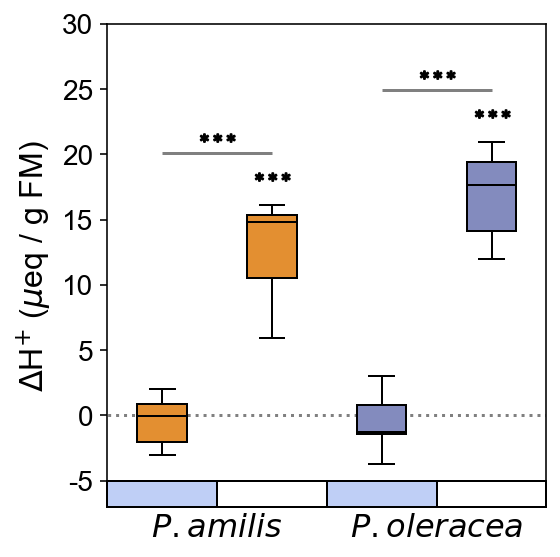

In [14]:
fig, ax = plt.subplots(figsize = (4,4))

for i in [0.5, 2.5]:
    ax.add_patch(plt.Rectangle(xy = (i, -7), width = 1 , height = 2,
                               facecolor='xkcd:blue', alpha=0.25, clip_on=False, linewidth = 1))
    ax.add_patch(plt.Rectangle(xy = (i, -7), width = 1 , height = 2, 
                               facecolor="none", clip_on=False, edgecolor ="black", linewidth = 1))
ax.add_patch(plt.Rectangle(xy = (0.5, -7), width = 4 , height = 2, 
                           facecolor="none", clip_on=False, edgecolor ="black", linewidth = 1))
ax.hlines(y=0, xmin=0, xmax=4.5, colors="grey", linestyles=":")

boxplot = ax.boxplot(patch_artist=True, x = [AM_w, AM_d, OF_w, OF_d])

for i, dist in enumerate([AM_w, AM_d, OF_w, OF_d]):
    result = stats.ttest_1samp(a=dist, popmean=0)
    if result.pvalue < 0.001: 
        marker = "$*$ $*$ $*$"
        size = 300
    elif result.pvalue < 0.01: 
        marker = "$*$ $*$"
        size = 300
    elif result.pvalue < 0.05: 
        marker = "$*$"
        size = 50
    else: 
        marker = ""
        size = 50
    ax.scatter(x = i+1, y = max(dist)+2, marker=marker, c="black", s=size)
    
for i, comp in enumerate([[AM_w, AM_d], [OF_w, OF_d]]):
    result = stats.ttest_ind(comp[0], comp[1])
    whisker_height = max(max(comp[0]), max(comp[1]))
    if result.pvalue < 0.001: 
        marker = "$*$ $*$ $*$"
        size = 300
    elif result.pvalue < 0.01: 
        marker = "$*$ $*$"
        size = 300
    elif result.pvalue < 0.05: 
        marker = "$*$"
        size = 50
    else: 
        marker = ""
        size = 50
    ax.hlines(y=whisker_height+4, xmin=2*i+1, xmax=2*i+2, colors="grey", linestyles="-")
    ax.scatter(x=2*i+1.5, y=whisker_height+5, marker=marker, c="black", s=size)

colors = [(227/255,143/255,49/255), (227/255,143/255,49/255), (131/255,139/255,190/255), (131/255,139/255,190/255), "xkcd:bluish", "xkcd:bluish"]
for color, box in zip(colors, boxplot["boxes"]):
    box.set_color(color)
    box.set_edgecolor("black")
for median in boxplot['medians']:
    median.set_color("black")   

ax.set_yticks(np.arange(-5,35,5))
ax.set_yticklabels(np.arange(-5,35,5), size=14)
ax.set_ylim([-7, 30])
ax.set_xlim([0.5, 4.5])
ax.set_xticks([1.5, 3.5])
ax.set_xticklabels(["$P. amilis$", "$P. oleracea$"], size=16)
ax.tick_params(axis='x', size=0)
ax.set_ylabel("$\Delta$H$^{+}$ ($\mu$eq / g FM)", size=16)
plt.tight_layout()
# plt.savefig("../Figures/AM-OF.deltaH_box.pdf", dpi = 300, transparent=True, bbox_to_inches="tight")

Now, the lines connecting the distributions show how significant the differences are between drought and well-watered conditions. Lines are only drawn between significantly different distributions.

In [18]:
stats.ttest_ind(AM_d, OF_d)

Ttest_indResult(statistic=-1.7129280064085757, pvalue=0.12087751485837116)